In [1]:
import csv
import pandas as pd
# time_align

def time_align(reference_file,temperature_file,humidity_file,Co2_file,output_file):
    # 读取 Reference 文件 # 
    reference_df = pd.read_csv(reference_file, skiprows=1) # skipros 第一行不读 row=0
    reference_df = reference_df.rename(columns={
        '#': 'Index',
        'Date Time, GMT+02:00': 'DateTime',
        'Temp, °C (LGR S/N: 10857593, SEN S/N: 10857593, LBL: Temp)': 'Temp_C',
        'RH, % (LGR S/N: 10857593, SEN S/N: 10857593, LBL: RH)': 'RH_%',
        'CO2, ppm (LGR S/N: 10857593, SEN S/N: 10857593, LBL: CO2)': 'CO2_ppm'
    })

    reference_df['DateTime'] = pd.to_datetime(reference_df['DateTime'], format='%m/%d/%y %I:%M:%S %p', errors='coerce')
    reference_df = reference_df.dropna(subset=['DateTime'])
    reference_df = reference_df[['DateTime', 'Temp_C', 'RH_%', 'CO2_ppm']].sort_values('DateTime')

    # 读取三个测量文件
    temp_df = pd.read_csv(temperature_file)
    temp_df['DateTime'] = pd.to_datetime(temp_df['Time'], errors='coerce')#errors coerce 非法日期转为 Nat
    temp_df = temp_df.rename(columns={'C': 'Temp_C_m'})[['DateTime', 'Temp_C_m']].sort_values('DateTime')

    rh_df = pd.read_csv(humidity_file)
    rh_df['DateTime'] = pd.to_datetime(rh_df['Time'], errors='coerce')
    rh_df = rh_df.rename(columns={'%': 'RH_%_m'})[['DateTime', 'RH_%_m']].sort_values('DateTime')

    co2_df = pd.read_csv(Co2_file)
    co2_df['DateTime'] = pd.to_datetime(co2_df['Time'], errors='coerce')
    co2_df = co2_df.rename(columns={'PPM': 'CO2_ppm_m'})[['DateTime', 'CO2_ppm_m']].sort_values('DateTime')

    # 时间对齐（nearest match，1分钟容差）
    merged_df = pd.merge_asof(reference_df, temp_df, on='DateTime', direction='nearest', tolerance=pd.Timedelta('1min'))
    merged_df = pd.merge_asof(merged_df, rh_df, on='DateTime', direction='nearest', tolerance=pd.Timedelta('1min'))
    merged_df = pd.merge_asof(merged_df, co2_df, on='DateTime', direction='nearest', tolerance=pd.Timedelta('1min'))
     # 只保留“没有任何缺失值”的完整行
    merged_df = merged_df.dropna()#.dropna delete Nan value
    # 写出对齐结果到 CSV
    merged_df.to_csv(output_file, index=False, encoding='utf-8-sig') 

    print(f"对齐完成，已输出到：{output_file}")

if __name__ == "__main__": # 
    refernce = 'Reference.csv'
    temperature ="T.csv"
    humidity ="RH.csv"
    Co2 ="co2.csv"
    output ="time_align_ouput.csv"
    time_align(refernce,temperature,humidity,Co2,output)

对齐完成，已输出到：time_align_ouput.csv


/var/folders/b6/jfxr36yn705djm1pctjzw6l00000gn/T/ipykernel_59952/3505441356.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  co2_df['DateTime'] = pd.to_datetime(co2_df['Time'], errors='coerce')


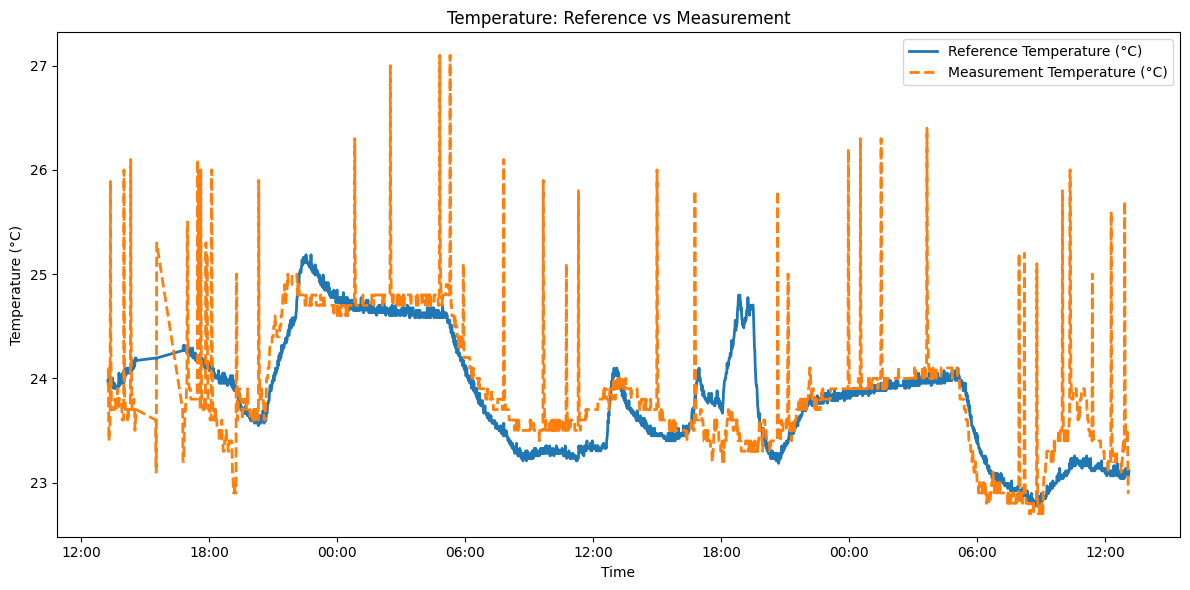

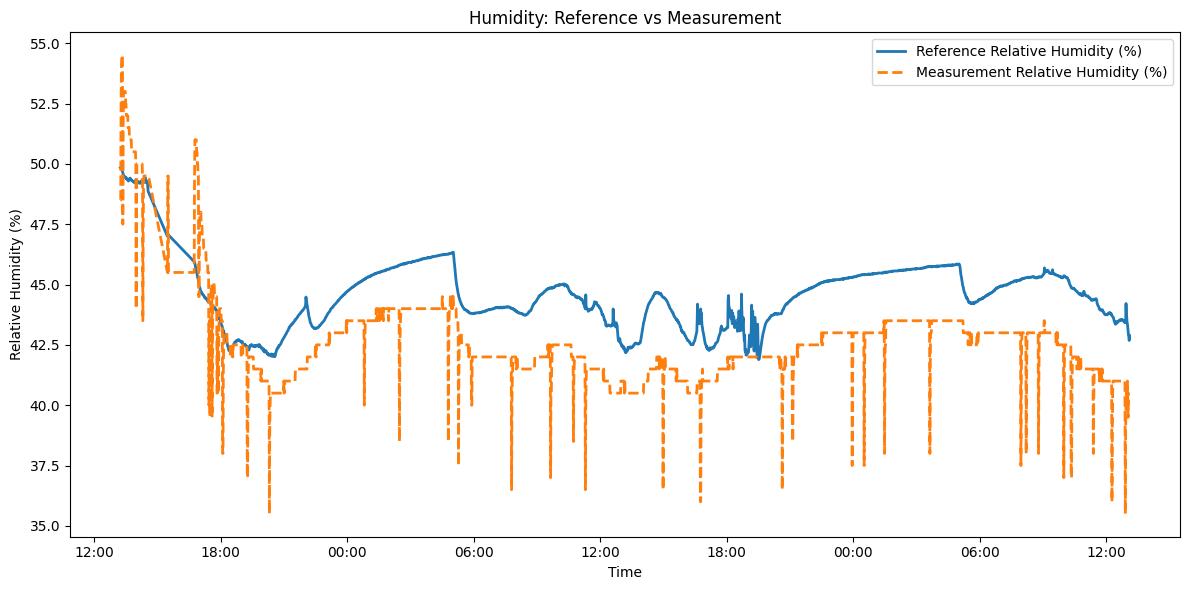

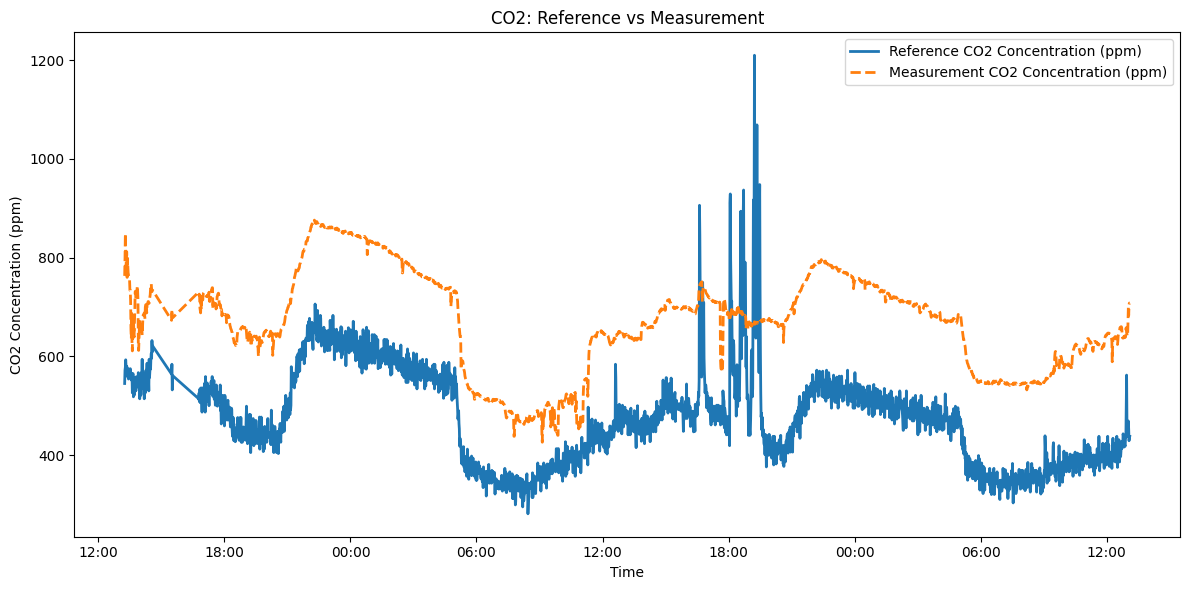

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# plot
#  读取 CSV 文件
file_path =  'time_align_ouput.csv'  
df = pd.read_csv(file_path)
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])

#  定义绘图函数（只显示小时和分钟）
def plot_reference_vs_measurement(df, ref_col, meas_col, ylabel, title):
    plt.figure(figsize=(12, 6))
    plt.plot(df['DateTime'], df[ref_col], label=f'Reference {ylabel}', linewidth=2)
    plt.plot(df['DateTime'], df[meas_col], label=f'Measurement {ylabel}', linewidth=2, linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    # 只显示小时:分钟
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.tight_layout()
    plt.show()

# 3. 绘制三张图

plot_reference_vs_measurement(df, 'Temp_C', 'Temp_C_m', 'Temperature (°C)', 'Temperature: Reference vs Measurement')
plot_reference_vs_measurement(df, 'RH_%', 'RH_%_m', 'Relative Humidity (%)', 'Humidity: Reference vs Measurement')
plot_reference_vs_measurement(df, 'CO2_ppm', 'CO2_ppm_m', 'CO2 Concentration (ppm)', 'CO2: Reference vs Measurement')

原始数据行数: 2740


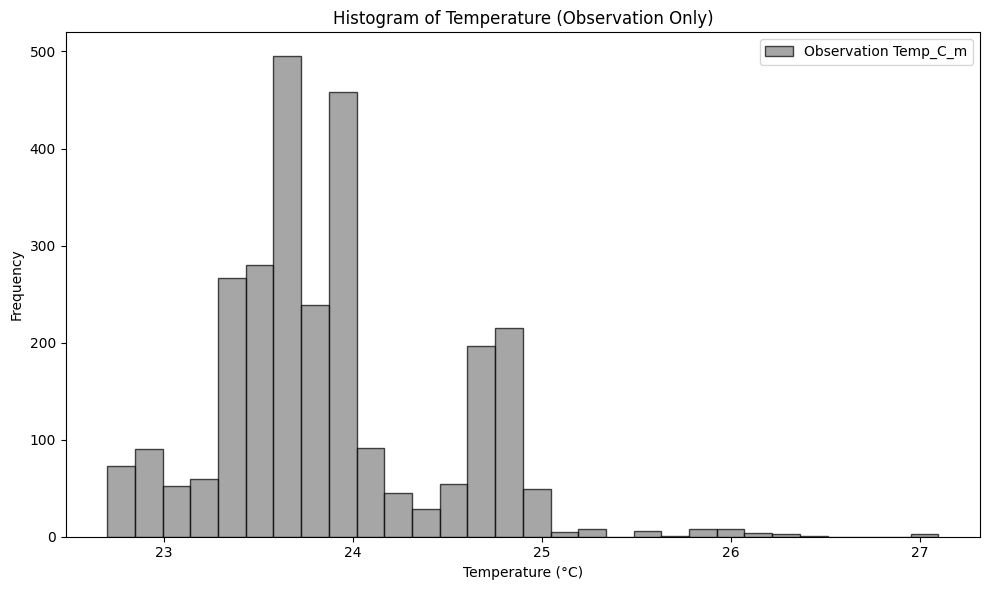

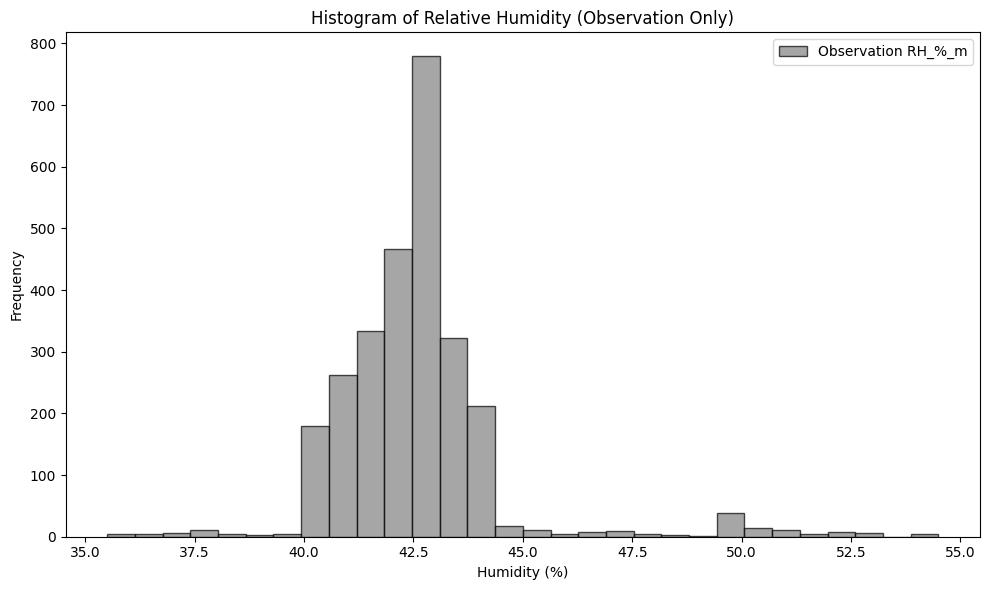

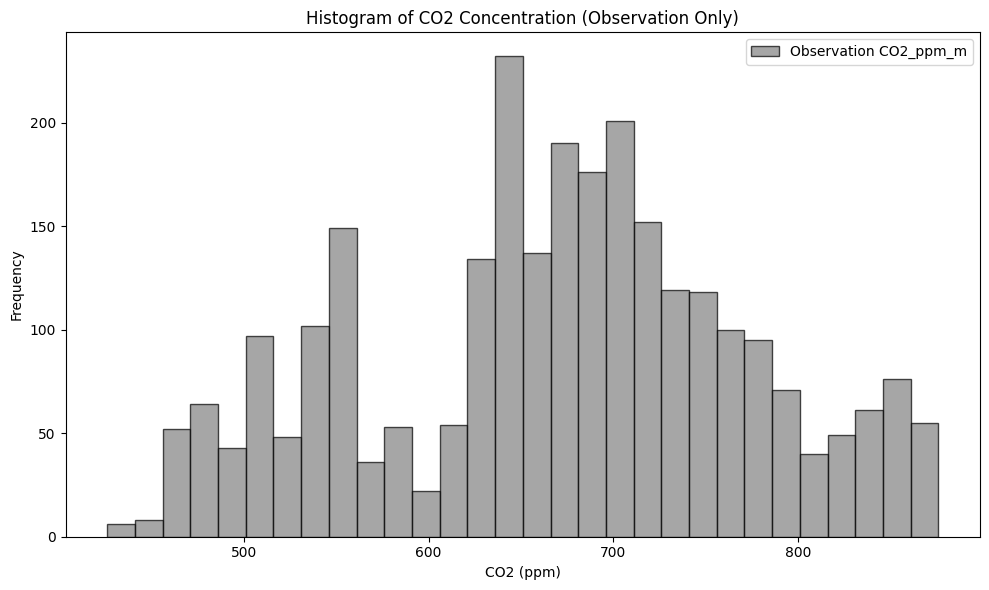

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# plot histogtam
def plot_histograms(df):
    def plot_hist(meas_col, title, xlabel):
        plt.figure(figsize=(10, 6))
        plt.hist(df[meas_col], bins=30, alpha=0.7, label=f'Observation {meas_col}', color='gray', edgecolor='black')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {title} (Observation Only)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_hist('Temp_C_m', 'Temperature', 'Temperature (°C)')
    plot_hist('RH_%_m', 'Relative Humidity', 'Humidity (%)')
    plot_hist('CO2_ppm_m', 'CO2 Concentration', 'CO2 (ppm)')


if __name__ == "__main__":
    file_path = 'time_align_ouput.csv'  
    df = pd.read_csv(file_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df = df.dropna(subset=['DateTime'])

    print(f"原始数据行数: {len(df)}")

     # 绘制直方图
    plot_histograms(df)

In [4]:
# 正态性检验
from scipy.stats import shapiro, kstest, norm, anderson
import pandas as pd
# normality test function
def normality_tests(series, label):
    data = series.dropna()# remove empty value

    # Shapiro-Wilk
    stat_sw, p_sw = shapiro(data)

    # Kolmogorov-Smirnov
    stat_ks, p_ks = kstest(data, 'norm', args=(data.mean(), data.std()))

    # Anderson-Darling
    result_ad = anderson(data, dist='norm')

    print(f"Result of Normality Test - {label}:")
    print(f"Shapiro-Wilk:       p = {p_sw:.4f} ({'Reject H0' if p_sw < 0.05 else 'Fail to reject H0'})")
    print(f"Kolmogorov-Smirnov: p = {p_ks:.4f} ({'Reject H0' if p_ks < 0.05 else 'Fail to reject H0'})")
    print(f"Anderson-Darling:   A² = {result_ad.statistic:.4f}")
    print(f"  Critical values: {result_ad.critical_values}")
    print(f"  Significance levels: {result_ad.significance_level}")




if __name__ == "__main__":
    file_path = 'time_align_ouput.csv'  
    df = pd.read_csv(file_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df = df.dropna(subset=['DateTime'])

    # 针对 Measurement 数据进行正态性检验
    normality_tests(df['Temp_C_m'], 'Temperature (°C)')
    normality_tests(df['RH_%_m'], 'Humidity (%)')
    normality_tests(df['CO2_ppm_m'], 'CO2 Concentration (ppm)')

Result of Normality Test - Temperature (°C):
Shapiro-Wilk:       p = 0.0000 (Reject H0)
Kolmogorov-Smirnov: p = 0.0000 (Reject H0)
Anderson-Darling:   A² = 63.0043
  Critical values: [0.575 0.655 0.786 0.917 1.09 ]
  Significance levels: [15.  10.   5.   2.5  1. ]
Result of Normality Test - Humidity (%):
Shapiro-Wilk:       p = 0.0000 (Reject H0)
Kolmogorov-Smirnov: p = 0.0000 (Reject H0)
Anderson-Darling:   A² = 147.5642
  Critical values: [0.575 0.655 0.786 0.917 1.09 ]
  Significance levels: [15.  10.   5.   2.5  1. ]
Result of Normality Test - CO2 Concentration (ppm):
Shapiro-Wilk:       p = 0.0000 (Reject H0)
Kolmogorov-Smirnov: p = 0.0000 (Reject H0)
Anderson-Darling:   A² = 14.9896
  Critical values: [0.575 0.655 0.786 0.917 1.09 ]
  Significance levels: [15.  10.   5.   2.5  1. ]


原始数据行数: 2740
清洗后数据行数: 2564


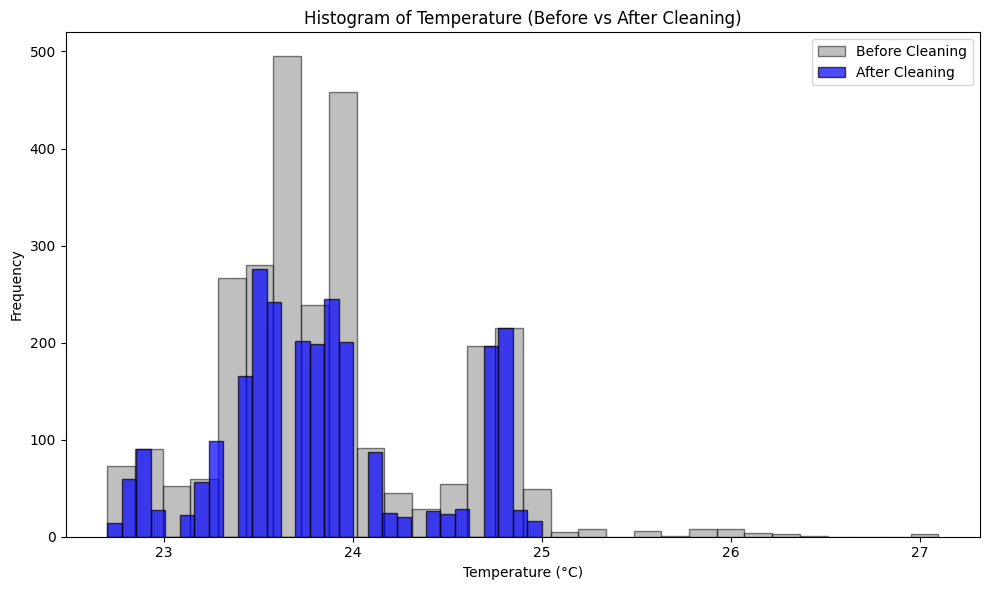

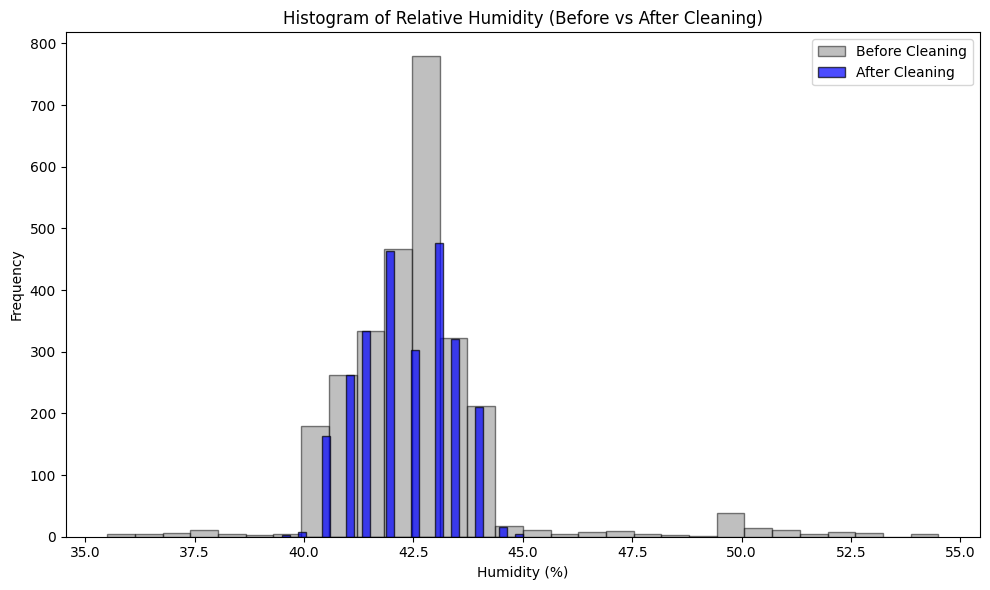

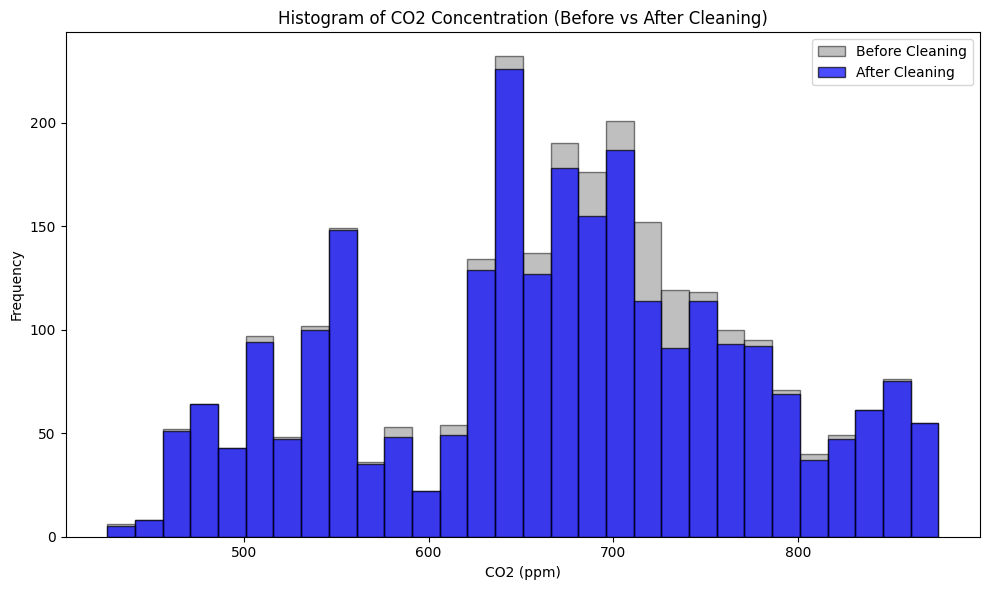

清洗后的数据已保存到 time_align_clean.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 绘制清洗前 vs 清洗后的直方图
def plot_histograms(df_before, df_after):
    def plot_hist(meas_col, title, xlabel):
        plt.figure(figsize=(10, 6))
        plt.hist(df_before[meas_col], bins=30, alpha=0.5, label='Before Cleaning', color='gray', edgecolor='black')
        plt.hist(df_after[meas_col], bins=30, alpha=0.7, label='After Cleaning', color='blue', edgecolor='black')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {title} (Before vs After Cleaning)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_hist('Temp_C_m', 'Temperature', 'Temperature (°C)')
    plot_hist('RH_%_m', 'Relative Humidity', 'Humidity (%)')
    plot_hist('CO2_ppm_m', 'CO2 Concentration', 'CO2 (ppm)')


# 异常值检测与剔除函数（只基于观测值）
def remove_outliers(df):
    def iqr_filter(df, meas_col):
        Q1, Q3 = df[meas_col].quantile(0.25), df[meas_col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        mask = (df[meas_col] >= lower) & (df[meas_col] <= upper)
        return df[mask]

    df_clean = iqr_filter(df, 'Temp_C_m')
    df_clean = iqr_filter(df_clean, 'RH_%_m')
    df_clean = iqr_filter(df_clean, 'CO2_ppm_m')

    return df_clean


if __name__ == "__main__":
    file_path = 'time_align_ouput.csv'
    df = pd.read_csv(file_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df = df.dropna(subset=['DateTime'])

    print(f"原始数据行数: {len(df)}")

    # 清洗
    df_clean = remove_outliers(df)

    print(f"清洗后数据行数: {len(df_clean)}")

    # 绘制直方图（清洗前 vs 清洗后）
    plot_histograms(df, df_clean)

    # 保存清洗后的数据
    output_file = 'time_align_clean.csv'
    df_clean.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"清洗后的数据已保存到 {output_file}")

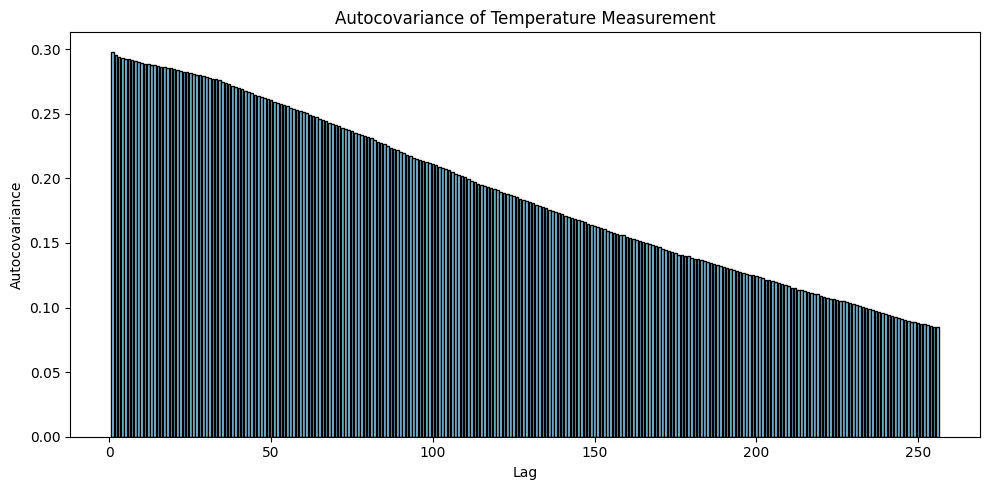

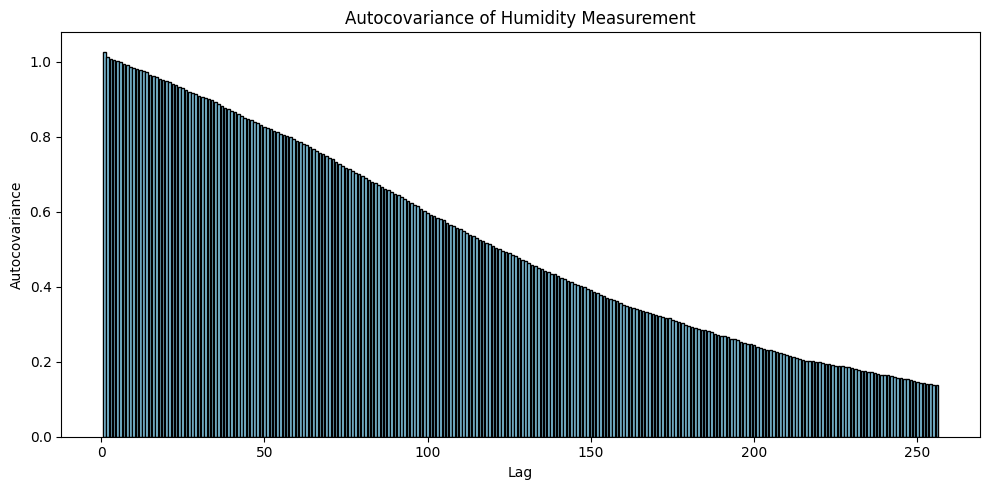

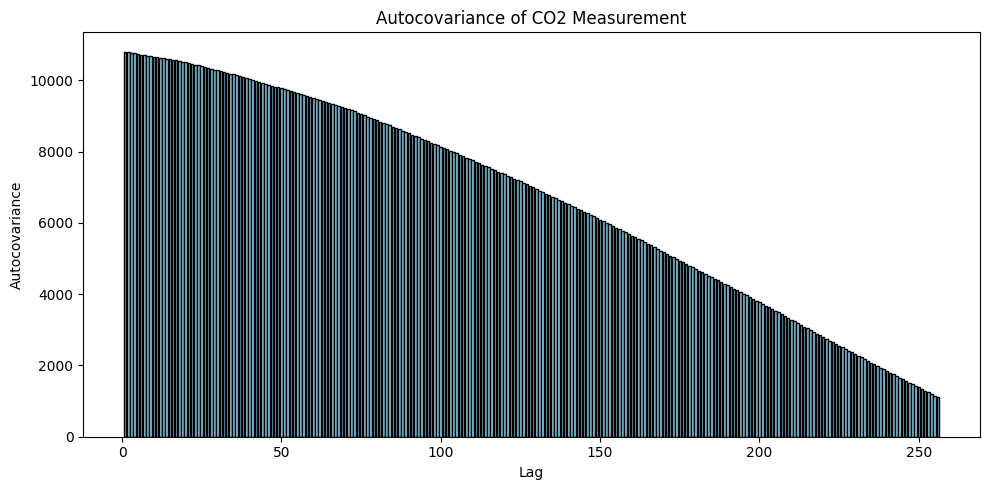

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 计算 autocovariance 的函数

def compute_autocovariance(series, max_lag=None):
    series = series.dropna().values
    n = len(series)

    if max_lag is None:
        max_lag = max(1, int(n / 10))  # 自动设置最大滞后阶数 

    mean = np.mean(series)
    autocovariances = []

    for lag in range(1, max_lag + 1):
        cov = np.sum((series[:-lag] - mean) * (series[lag:] - mean)) / (n - lag)
        autocovariances.append(cov)

    return autocovariances



def plot_autocovariance(series, max_lag, title):
    autocov = compute_autocovariance(series, max_lag)
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, len(autocov) + 1), autocov, color='skyblue', edgecolor='black')
    plt.xlabel('Lag')
    plt.ylabel('Autocovariance')
    plt.title(title)
    plt.tight_layout()
    plt.show()





if __name__ == "__main__":
    file_path = 'time_align_clean.csv'  #
    df = pd.read_csv(file_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df = df.dropna(subset=['DateTime'])

    # 自动计算 max_lag
    max_lag_temp = None
    max_lag_rh = None
    max_lag_co2 = None

    # Temperature autocovariance
    plot_autocovariance(df['Temp_C_m'], max_lag_temp, 'Autocovariance of Temperature Measurement')

    # Humidity autocovariance
    plot_autocovariance(df['RH_%_m'], max_lag_rh, 'Autocovariance of Humidity Measurement')

    # CO2 autocovariance
    plot_autocovariance(df['CO2_ppm_m'], max_lag_co2, 'Autocovariance of CO2 Measurement')


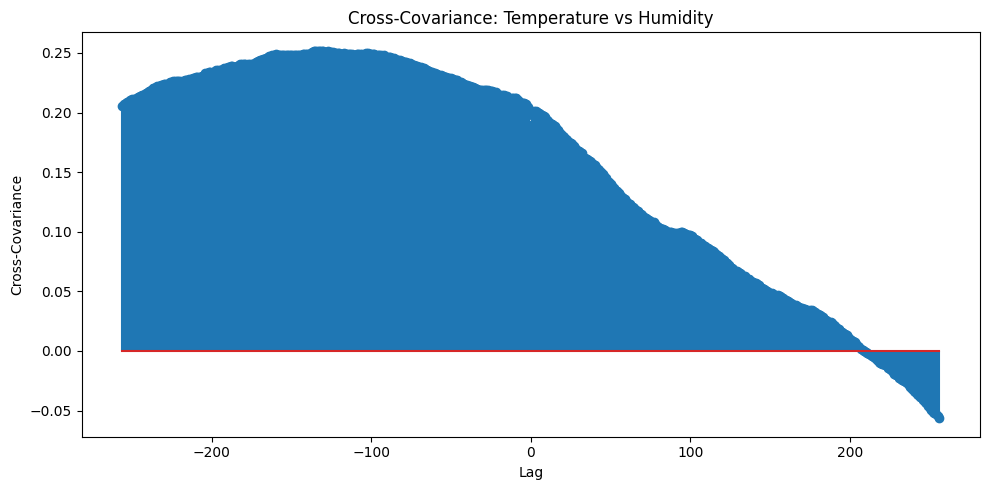

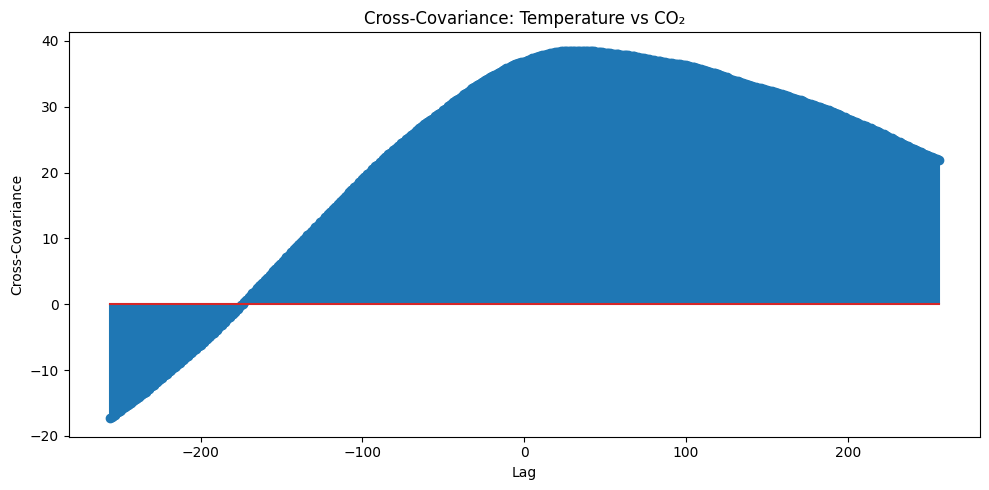

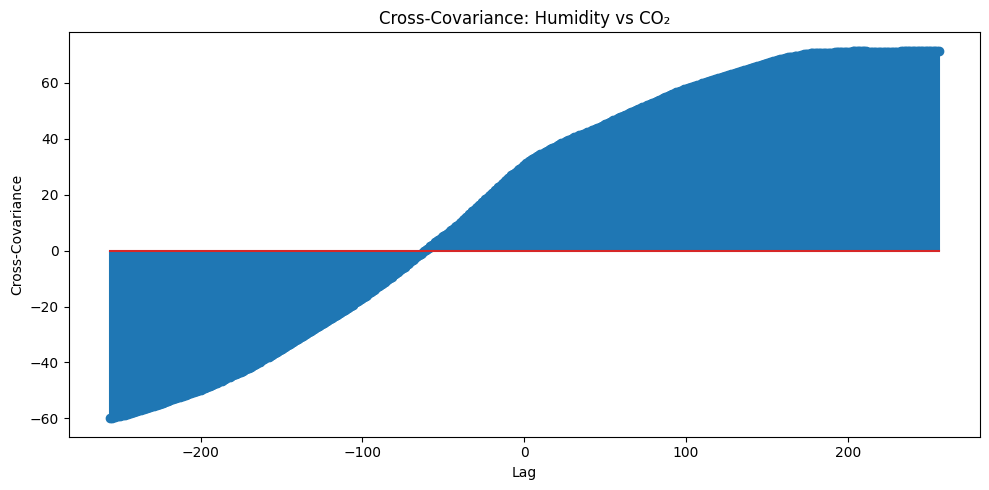

In [8]:
# cross-covariance between 2 elements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 计算 Cross-Covariance 的函数
def compute_cross_covariance(series_x, series_y, max_lag=None):
    series_x = series_x.dropna().values
    series_y = series_y.dropna().values

    n = min(len(series_x), len(series_y))
    series_x = series_x[:n]
    series_y = series_y[:n]

    if max_lag is None:
        max_lag = max(1, int(n / 10))

    mean_x = np.mean(series_x)
    mean_y = np.mean(series_y)

    lags = np.arange(-max_lag, max_lag + 1)
    cross_cov = []

    for lag in lags:
        if lag < 0:
            cov = np.sum((series_x[:lag] - mean_x) * (series_y[-lag:] - mean_y)) / (n - abs(lag))
        elif lag > 0:
            cov = np.sum((series_x[lag:] - mean_x) * (series_y[:-lag] - mean_y)) / (n - lag)
        else:
            cov = np.sum((series_x - mean_x) * (series_y - mean_y)) / n
        cross_cov.append(cov)

    return lags, cross_cov

def plot_cross_covariance(series_x, series_y, max_lag, title):
    lags, cross_cov = compute_cross_covariance(series_x, series_y, max_lag)
    plt.figure(figsize=(10, 5))
    plt.stem(lags, cross_cov)  # 去掉 use_line_collection
    plt.xlabel('Lag')
    plt.ylabel('Cross-Covariance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 主函数
if __name__ == "__main__":
    file_path = 'time_align_clean.csv'
    df = pd.read_csv(file_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df = df.dropna(subset=['DateTime'])

    # 自动 max_lag
    max_lag = None

    # Temperature vs Humidity
    plot_cross_covariance(df['Temp_C_m'], df['RH_%_m'], max_lag, 'Cross-Covariance: Temperature vs Humidity')

    # Temperature vs CO2
    plot_cross_covariance(df['Temp_C_m'], df['CO2_ppm_m'], max_lag, 'Cross-Covariance: Temperature vs CO₂')

    # Humidity vs CO2
    plot_cross_covariance(df['RH_%_m'], df['CO2_ppm_m'], max_lag, 'Cross-Covariance: Humidity vs CO₂')

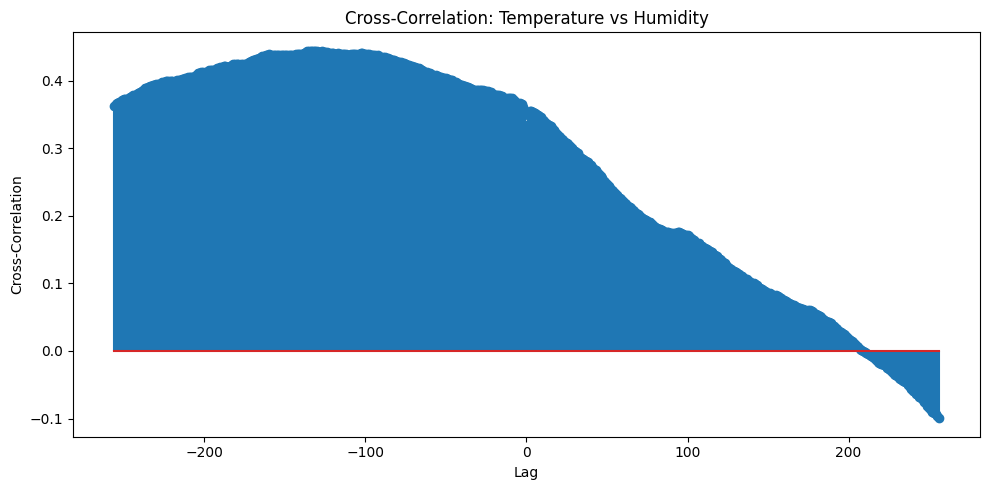

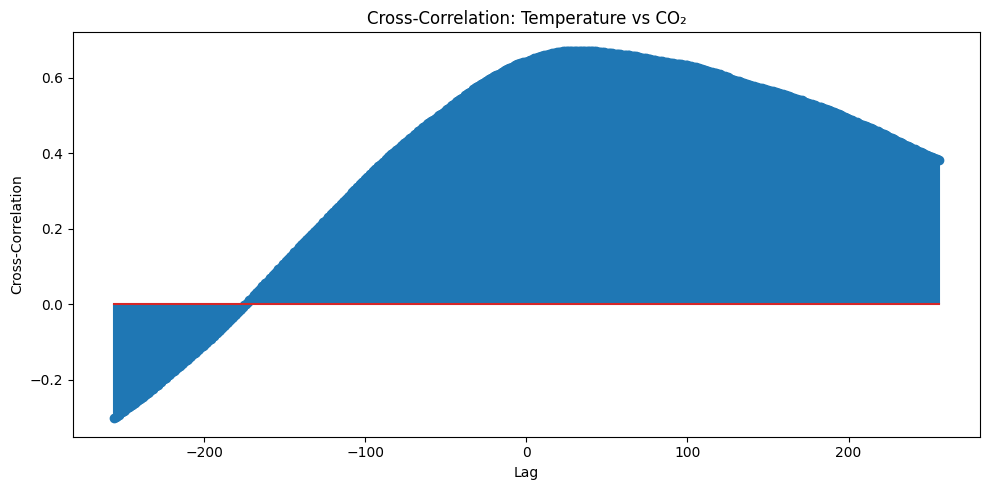

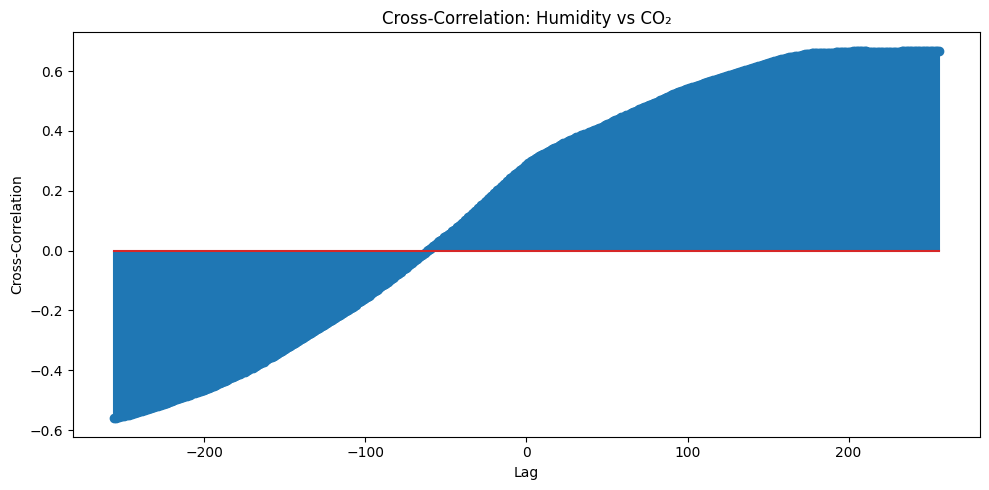

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 计算 Cross-Correlation 的函数
def compute_cross_correlation(series_x, series_y, max_lag=None):
    series_x = series_x.dropna().values
    series_y = series_y.dropna().values

    n = min(len(series_x), len(series_y))
    series_x = series_x[:n]
    series_y = series_y[:n]

    if max_lag is None:
        max_lag = max(1, int(n / 10))

    mean_x = np.mean(series_x)
    mean_y = np.mean(series_y)
    std_x = np.std(series_x)
    std_y = np.std(series_y)

    lags = np.arange(-max_lag, max_lag + 1)
    cross_corr = []

    for lag in lags:
        if lag < 0:
            cov = np.sum((series_x[:lag] - mean_x) * (series_y[-lag:] - mean_y)) / (n - abs(lag))
        elif lag > 0:
            cov = np.sum((series_x[lag:] - mean_x) * (series_y[:-lag] - mean_y)) / (n - lag)
        else:
            cov = np.sum((series_x - mean_x) * (series_y - mean_y)) / n

        corr = cov / (std_x * std_y)  # 标准化为相关系数
        cross_corr.append(corr)

    return lags, cross_corr

# 绘制 Cross-Correlation 图
def plot_cross_correlation(series_x, series_y, max_lag, title):
    lags, cross_corr = compute_cross_correlation(series_x, series_y, max_lag)
    plt.figure(figsize=(10, 5))
    plt.stem(lags, cross_corr)
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 主函数
if __name__ == "__main__":
    file_path = 'time_align_clean.csv'
    df = pd.read_csv(file_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df = df.dropna(subset=['DateTime'])

    max_lag = None

    # Temperature vs Humidity
    plot_cross_correlation(df['Temp_C_m'], df['RH_%_m'], max_lag, 'Cross-Correlation: Temperature vs Humidity')

    # Temperature vs CO2
    plot_cross_correlation(df['Temp_C_m'], df['CO2_ppm_m'], max_lag, 'Cross-Correlation: Temperature vs CO₂')

    # Humidity vs CO2
    plot_cross_correlation(df['RH_%_m'], df['CO2_ppm_m'], max_lag, 'Cross-Correlation: Humidity vs CO₂')

In [10]:
import pandas as pd
import plotly.graph_objects as go

# 主函数
def plot_3d_interactive(df):
    fig = go.Figure()

    # Reference scatter
    fig.add_trace(go.Scatter3d(
        x=df['Temp_C'],
        y=df['RH_%'],
        z=df['CO2_ppm'],
        mode='markers',
        marker=dict(size=4, color='blue'),
        name='Reference'
    ))

    # Measurement scatter
    fig.add_trace(go.Scatter3d(
        x=df['Temp_C_m'],
        y=df['RH_%_m'],
        z=df['CO2_ppm_m'],
        mode='markers',
        marker=dict(size=4, color='red'),
        name='Measurement'
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='Temperature (°C)',
            yaxis_title='Humidity (%)',
            zaxis_title='CO2 (ppm)'
        ),
        title='3D Scatter Plot: Reference vs Measurement (Interactive)',
        legend=dict(x=0, y=1)
    )

    fig.show()

if __name__ == "__main__":
    file_path = 'time_align_clean.csv'
    df = pd.read_csv(file_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df = df.dropna(subset=['DateTime'])

    plot_3d_interactive(df)


Temperature 主导频率: 0.000013 Hz
Temperature 主导周期: 76920.0 秒 ≈ 1282.00 分钟 ≈ 21.37 小时


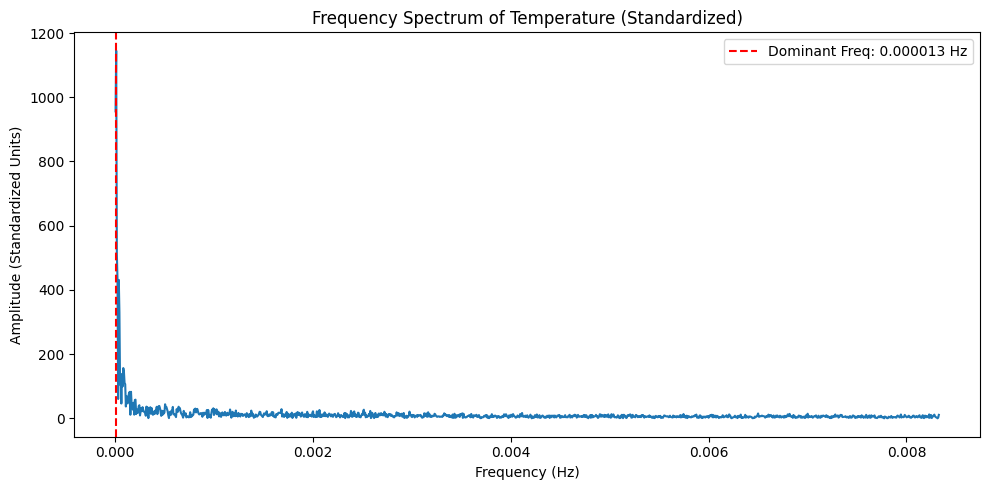


Humidity 主导频率: 0.000013 Hz
Humidity 主导周期: 76920.0 秒 ≈ 1282.00 分钟 ≈ 21.37 小时


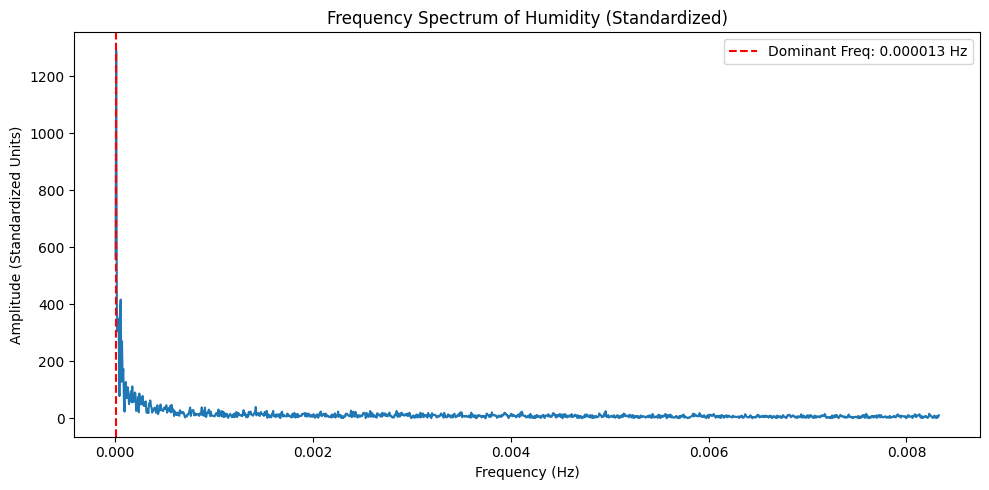


CO2 主导频率: 0.000013 Hz
CO2 主导周期: 76920.0 秒 ≈ 1282.00 分钟 ≈ 21.37 小时


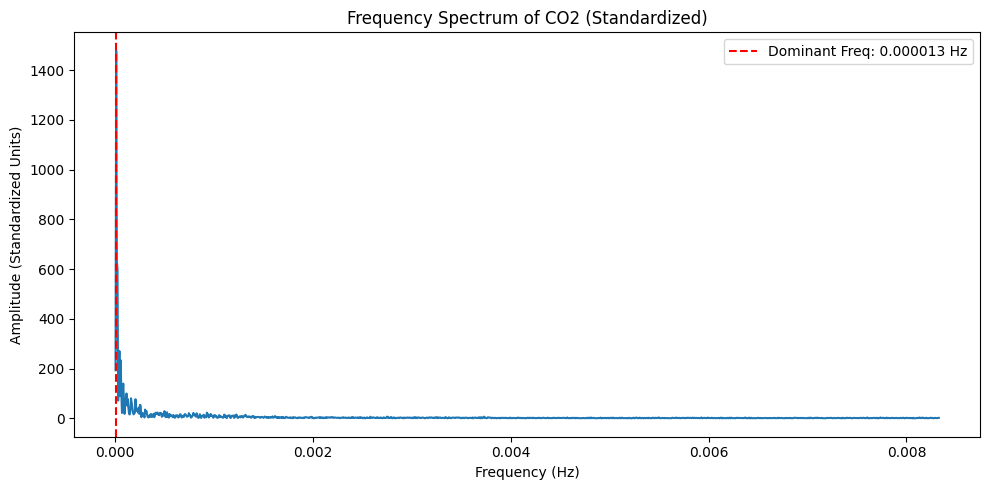

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#分析原始变量（真实的传感器读数）
# 1. 读取数据
file_path = 'time_align_clean.csv'
df = pd.read_csv(file_path)
df = df.dropna(subset=['Temp_C_m', 'RH_%_m', 'CO2_ppm_m', 'DateTime'])
df['DateTime'] = pd.to_datetime(df['DateTime'])

# 2. 标准化变量
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Temp_C_m', 'RH_%_m', 'CO2_ppm_m']])

variables = {
    'Temperature': X_scaled[:, 0],
    'Humidity': X_scaled[:, 1],
    'CO2': X_scaled[:, 2]
}

# 3. 采样信息
n = len(df)
sampling_interval_seconds = 60  # 每分钟采样一次
sampling_rate_hz = 1 / sampling_interval_seconds

freqs = np.fft.fftfreq(n, d=sampling_interval_seconds)
mask = freqs > 0  # 正频率

# 4. 绘制频谱并自动找主导频率和周期
for name, series in variables.items():
    fft_values = np.fft.fft(series)
    magnitude = np.abs(fft_values)

    freqs_pos = freqs[mask]
    magnitude_pos = magnitude[mask]

    dominant_idx = np.argmax(magnitude_pos)
    dominant_freq_hz = freqs_pos[dominant_idx]
    dominant_period_sec = 1 / dominant_freq_hz
    dominant_period_min = dominant_period_sec / 60
    dominant_period_hr = dominant_period_min / 60

    print(f'\n{name} 主导频率: {dominant_freq_hz:.6f} Hz')
    print(f'{name} 主导周期: {dominant_period_sec:.1f} 秒 ≈ {dominant_period_min:.2f} 分钟 ≈ {dominant_period_hr:.2f} 小时')

    plt.figure(figsize=(10, 5))
    plt.plot(freqs_pos, magnitude_pos)
    plt.axvline(dominant_freq_hz, color='red', linestyle='--', label=f'Dominant Freq: {dominant_freq_hz:.6f} Hz')
    plt.title(f'Frequency Spectrum of {name} (Standardized)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (Standardized Units)')
    plt.legend()
    plt.tight_layout()
    plt.show()


Temperature Error 主导频率: 0.000046 Hz
Temperature Error 主导周期: 21977.1 秒 ≈ 366.29 分钟 ≈ 6.10 小时


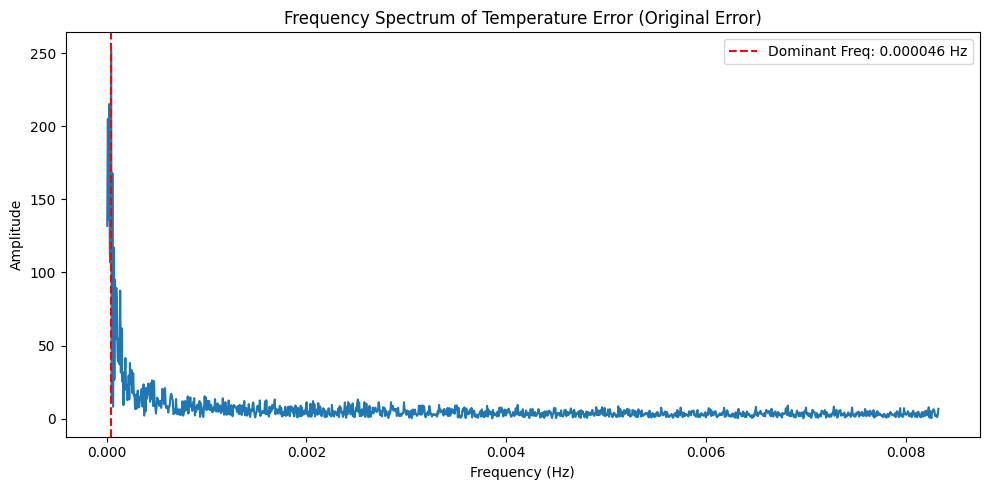

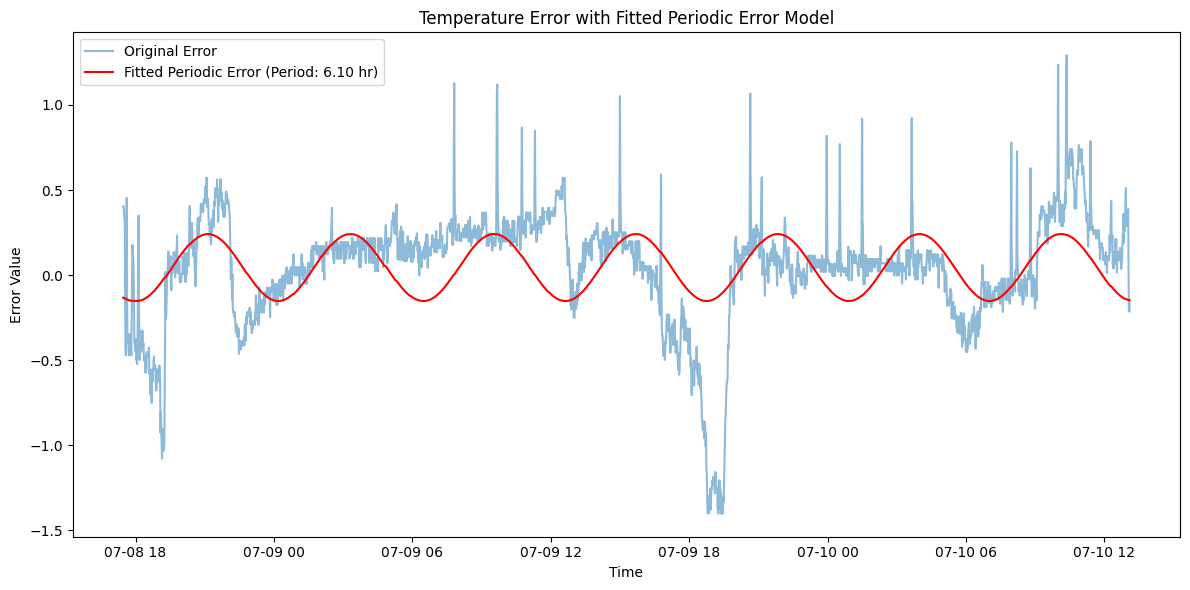

Temperature Error 周期性误差模型参数: 振幅=-0.197, 角频率=0.000288, 相位=1.119, 偏移=0.045

Humidity Error 主导频率: 0.000046 Hz
Humidity Error 主导周期: 21977.1 秒 ≈ 366.29 分钟 ≈ 6.10 小时


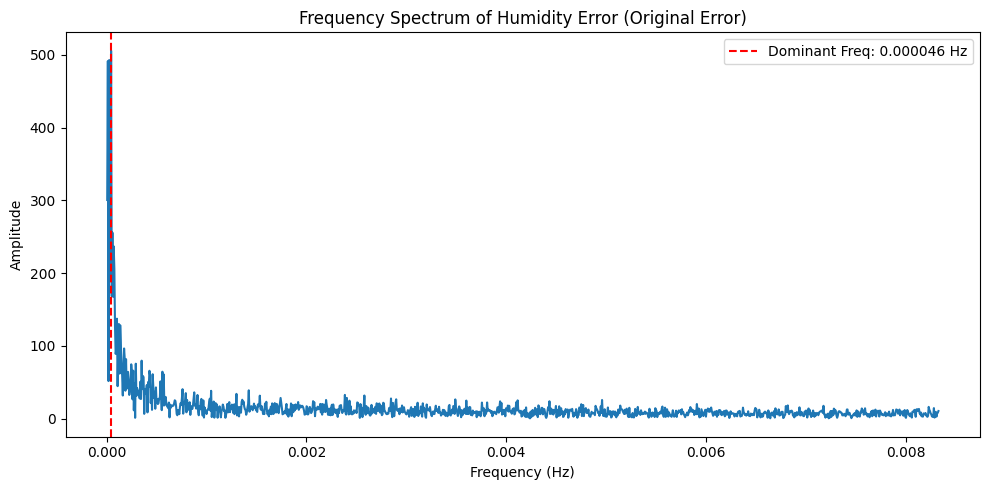

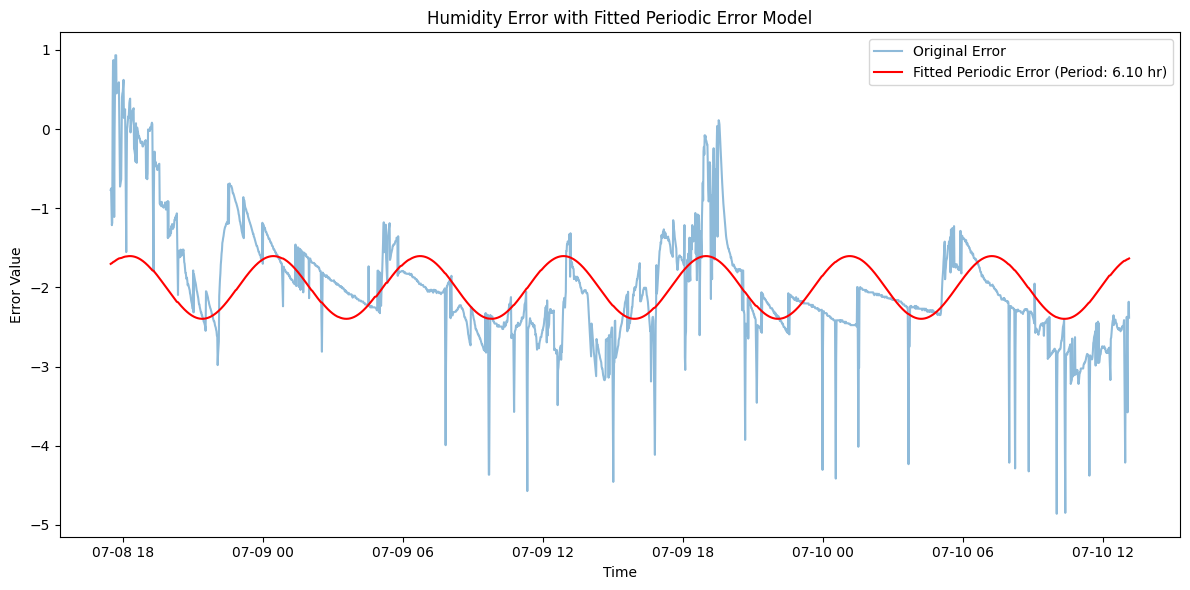

Humidity Error 周期性误差模型参数: 振幅=0.396, 角频率=0.000288, 相位=0.850, 偏移=-2.001

CO2 Error 主导频率: 0.000007 Hz
CO2 Error 主导周期: 153840.0 秒 ≈ 2564.00 分钟 ≈ 42.73 小时


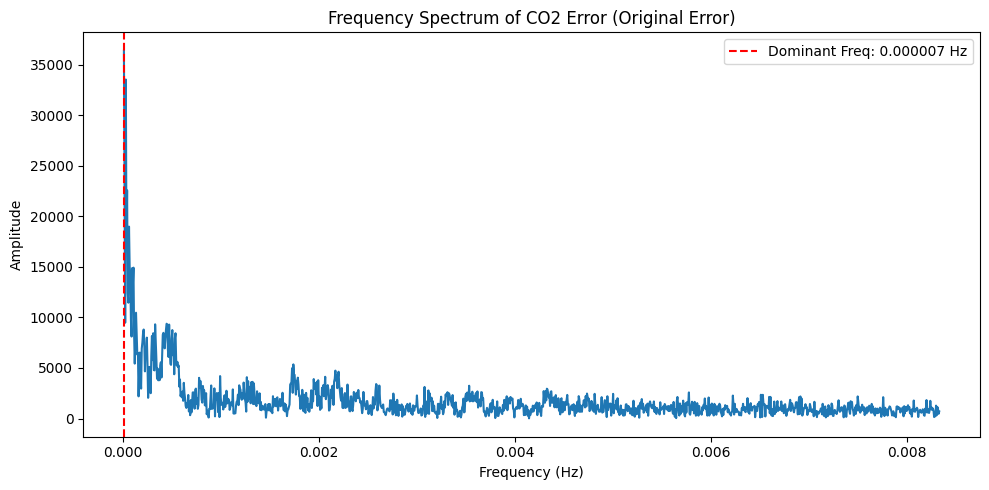

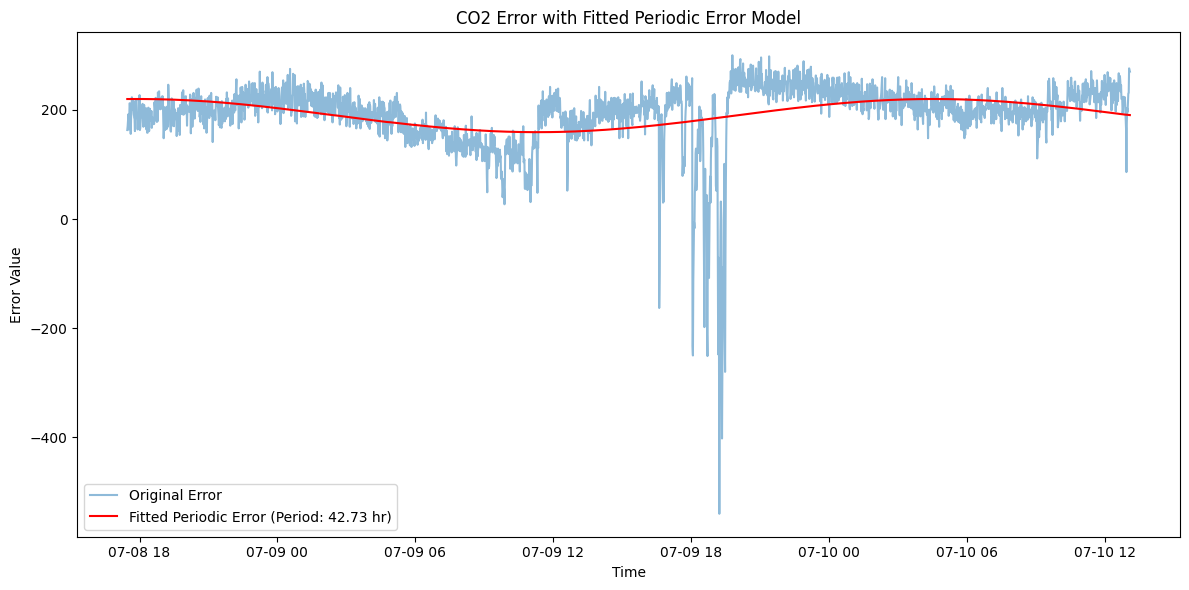

CO2 Error 周期性误差模型参数: 振幅=-30.387, 角频率=0.000051, 相位=-1.629, 偏移=189.499


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#分析误差（m值 - 原值）
# 1. 读取数据
file_path = 'time_align_clean.csv'
df = pd.read_csv(file_path)
df = df.dropna(subset=['Temp_C_m', 'RH_%_m', 'CO2_ppm_m', 'Temp_C', 'RH_%', 'CO2_ppm', 'DateTime'])
df['DateTime'] = pd.to_datetime(df['DateTime'])

# 2. 计算误差（不标准化，保留真实幅度）
df['Temp_error'] = df['Temp_C_m'] - df['Temp_C']
df['RH_error'] = df['RH_%_m'] - df['RH_%']
df['CO2_error'] = df['CO2_ppm_m'] - df['CO2_ppm']

errors = {
    'Temperature Error': df['Temp_error'].values,
    'Humidity Error': df['RH_error'].values,
    'CO2 Error': df['CO2_error'].values
}

n = len(df)
sampling_interval_seconds = 60  # 每分钟一次
freqs = np.fft.fftfreq(n, d=sampling_interval_seconds)
mask = freqs > 0

# 3. 定义正弦拟合函数
def sine_func(t, A, omega, phase, offset):
    return A * np.sin(omega * t + phase) + offset

# 4. 分析每个误差序列
for name, series in errors.items():
    time_seconds = np.arange(n) * sampling_interval_seconds

    # 4.1 傅里叶变换
    fft_values = np.fft.fft(series)
    magnitude = np.abs(fft_values)

    freqs_pos = freqs[mask]
    magnitude_pos = magnitude[mask]

    dominant_idx = np.argmax(magnitude_pos)
    dominant_freq_hz = freqs_pos[dominant_idx]
    dominant_period_sec = 1 / dominant_freq_hz
    dominant_period_min = dominant_period_sec / 60
    dominant_period_hr = dominant_period_min / 60

    print(f'\n{name} 主导频率: {dominant_freq_hz:.6f} Hz')
    print(f'{name} 主导周期: {dominant_period_sec:.1f} 秒 ≈ {dominant_period_min:.2f} 分钟 ≈ {dominant_period_hr:.2f} 小时')

    # 4.2 绘制频谱
    plt.figure(figsize=(10, 5))
    plt.plot(freqs_pos, magnitude_pos)
    plt.axvline(dominant_freq_hz, color='red', linestyle='--', label=f'Dominant Freq: {dominant_freq_hz:.6f} Hz')
    plt.title(f'Frequency Spectrum of {name} (Original Error)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4.3 周期性误差模型拟合
    dominant_omega = 2 * np.pi * dominant_freq_hz  # 角频率

    guess_amplitude = (np.max(series) - np.min(series)) / 2
    guess_offset = np.mean(series)

    try:
        popt, _ = curve_fit(sine_func, time_seconds, series,
                            p0=[guess_amplitude, dominant_omega, 0, guess_offset],
                            maxfev=10000)

        fitted_curve = sine_func(time_seconds, *popt)

        # 4.4 可视化拟合结果
        plt.figure(figsize=(12,6))
        plt.plot(df['DateTime'], series, label='Original Error', alpha=0.5)
        plt.plot(df['DateTime'], fitted_curve, label=f'Fitted Periodic Error (Period: {dominant_period_hr:.2f} hr)', color='red')
        plt.title(f'{name} with Fitted Periodic Error Model')
        plt.xlabel('Time')
        plt.ylabel('Error Value')
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f"{name} 周期性误差模型参数: 振幅={popt[0]:.3f}, 角频率={popt[1]:.6f}, 相位={popt[2]:.3f}, 偏移={popt[3]:.3f}")

    except RuntimeError:
        print(f"{name} 拟合失败，可能没有明显的周期性误差。")